# outliers

In [18]:
import addict
import numpy as np
import pandas as pd
from data_io import load_train_features, load_test_features
from validator import KFoldValidator
from models import LGBModel
from my_logger import print_info


def main():
    model_name = "outlier005"
    train_data = load_train_features()
    print_info("train_data.shape", train_data.shape)
    print_info("train_data.head", train_data.head())

    features = list(train_data.columns)
    features.remove("card_id")
    features.remove("target")

    id_train = train_data.card_id.values
    X_train = train_data[features].values
    y_train = train_data.target.values
    y_train = (y_train < -33).astype(np.int32)

    print_info("id_train.shape", id_train.shape)
    print_info("X_train.shape", X_train.shape)
    print_info("y_train.shape", y_train.shape)

    test_data = load_test_features()
    id_test = test_data.card_id.values
    X_test = test_data[features].values
    print_info("id_test.shape", id_test.shape)
    print_info("X_test.shape", X_test.shape)

In [21]:
import matplotlib.pyplot as plt

# load data

In [2]:
train_data = load_train_features()
print_info("train_data.shape", train_data.shape)
print_info("train_data.head", train_data.head())

features = list(train_data.columns)
features.remove("card_id")
features.remove("target")

id_train = train_data.card_id.values
X_train = train_data[features].values
y_train = train_data.target.values
y_train = (y_train < -33).astype(np.int32)

[info] train_data.shape : (201917, 501)
[info] train_data.head :    feature_1  feature_2  feature_3    target          card_id  fa_month  \
0        5.0        2.0        1.0 -0.820283  C_ID_92a2005557  201706.0   
1        4.0        1.0        0.0  0.392913  C_ID_3d0044924f  201701.0   
2        2.0        2.0        0.0  0.688056  C_ID_d639edf6cd  201608.0   
3        4.0        3.0        0.0  0.142495  C_ID_186d6a6901  201709.0   
4        1.0        3.0        0.0 -0.159749  C_ID_cdbd2c0db2  201711.0   

   purchase_amount_sum_hist_trans  purchase_amount_mean_hist_trans  \
0                     -165.968735                        -0.638341   
1                     -210.006332                        -0.600018   
2                      -29.167391                        -0.678311   
3                      -49.491364                        -0.642745   
4                      -48.687656                        -0.366073   

   purchase_amount_max_hist_trans  purchase_amount_min_hist_tra

In [8]:
train_data["outlier"] = (train_data.target < -33)

In [4]:
train_data[["feature_1", "feature_2", "feature_3"]].head().T

,0,1,2,3,4
feature_1,5.0,4.0,2.0,4.0,1.0
feature_2,2.0,1.0,2.0,3.0,3.0
feature_3,1.0,0.0,0.0,0.0,0.0


In [6]:
train_data.groupby(["feature_1", "feature_2", "feature_3"]).size().reset_index()

,feature_1,feature_2,feature_3,0
0,1.0,1.0,0.0,6508
1,1.0,2.0,0.0,2833
2,1.0,3.0,0.0,2696
3,2.0,1.0,0.0,24502
4,2.0,2.0,0.0,24469
5,2.0,3.0,0.0,6826
6,3.0,1.0,1.0,24610
7,3.0,2.0,1.0,24417
8,3.0,3.0,1.0,24546
9,4.0,1.0,0.0,9194


In [7]:
train_data.groupby(["feature_1", "feature_2", "feature_3"]).target.mean().reset_index()

,feature_1,feature_2,feature_3,target
0,1.0,1.0,0.0,-0.225825
1,1.0,2.0,0.0,-0.304027
2,1.0,3.0,0.0,-0.543918
3,2.0,1.0,0.0,-0.409332
4,2.0,2.0,0.0,-0.302688
5,2.0,3.0,0.0,-0.310319
6,3.0,1.0,1.0,-0.266980
7,3.0,2.0,1.0,-0.296476
8,3.0,3.0,1.0,-0.569006
9,4.0,1.0,0.0,-0.413791


In [9]:
train_data.groupby(["feature_1", "feature_2", "feature_3"]).outlier.mean().reset_index()

,feature_1,feature_2,feature_3,outlier
0,1.0,1.0,0.0,0.005378
1,1.0,2.0,0.0,0.011295
2,1.0,3.0,0.0,0.011128
3,2.0,1.0,0.0,0.013387
4,2.0,2.0,0.0,0.008133
5,2.0,3.0,0.0,0.009522
6,3.0,1.0,1.0,0.007070
7,3.0,2.0,1.0,0.007904
8,3.0,3.0,1.0,0.016459
9,4.0,1.0,0.0,0.009898


In [23]:
def merge_feature(data, encoder, is_train):
    import addict
    data["feature_mg"] = (data.feature_1 * 100 + data.feature_2 * 10 + data.feature_3).astype(np.int32)
    if is_train:
        encoder.freq_encoder = data.feature_mg.value_counts()
        encoder.outlier_encoder = data.groupby("feature_mg").outlier.mean()
        encoder.raw_encoder = data.groupby("feature_mg").target.mean()
        encoder.pure_encoder = data[data.target > -33].groupby("feature_mg").target.mean()
    data["feature_freq"] = data.feature_mg.map(encoder.freq_encoder)
    data["feature_outlier"] = data.feature_mg.map(encoder.outlier_encoder)
    data["feature_raw"] = data.feature_mg.map(encoder.raw_encoder)
    data["feature_pure"] = data.feature_mg.map(encoder.pure_encoder)
    return data

In [12]:
train_data = merge_feature(train_data)

In [19]:
mean_ecd = pd.DataFrame({
    "mix_mean": train_data.groupby("feature_mg").target.mean(),
    "raw_mean": train_data[train_data.target > -33].groupby("feature_mg").target.mean()
})

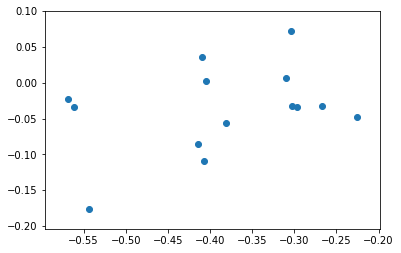

In [22]:
plt.scatter(mean_ecd.mix_mean, mean_ecd.raw_mean)

In [15]:
train_data.groupby("feature_mg").target.mean().sort_index()

feature_mg
110   -0.225825
120   -0.304027
130   -0.543918
210   -0.409332
220   -0.302688
230   -0.310319
311   -0.266980
321   -0.296476
331   -0.569006
410   -0.413791
420   -0.405038
430   -0.381644
511   -0.561022
521   -0.407664
Name: target, dtype: float32

In [16]:
train_data[train_data.target > -33].groupby("feature_mg").target.mean().sort_index()

feature_mg
110   -0.047427
120    0.072014
130   -0.176228
210    0.035844
220   -0.032791
230    0.006067
311   -0.032338
321   -0.034170
331   -0.022626
410   -0.085844
420    0.002861
430   -0.055996
511   -0.033926
521   -0.109210
Name: target, dtype: float32

In [13]:
train_data.feature_mg.value_counts()

311    24610
331    24546
210    24502
220    24469
511    24428
321    24417
521    16197
410     9194
420     6923
230     6826
110     6508
430     3768
120     2833
130     2696
Name: feature_mg, dtype: int64